# Day 6: t-SNE & UMAP Visualization

## 🎯 Learning Objectives
- Understand dimensionality reduction for visualization
- Apply t-SNE and UMAP to market data
- Visualize market regimes and asset relationships

---

## 📚 Theory

### t-SNE (t-Distributed Stochastic Neighbor Embedding)
- Non-linear dimensionality reduction
- Preserves local structure
- Good for visualization

### UMAP (Uniform Manifold Approximation)
- Faster than t-SNE
- Better global structure preservation
- Works well with clustering

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252

# Download multiple assets
tickers = ['SPY', 'QQQ', 'IWM', 'TLT', 'GLD', 'XLF', 'XLE', 'XLK', 'XLV', 'XLI',
           'XLY', 'XLP', 'XLU', 'EEM', 'VNQ', 'USO', 'SLV', 'DIA', 'AGG', 'HYG']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(returns)} days, {len(tickers)} assets")

📥 Downloading data...
✅ Data: 1253 days, 20 assets


In [2]:
# Create rolling features for each day
window = 20
features = pd.DataFrame(index=returns.index[window:])

for ticker in tickers:
    features[f'{ticker}_ret'] = returns[ticker].rolling(window).mean().iloc[window:]
    features[f'{ticker}_vol'] = returns[ticker].rolling(window).std().iloc[window:]

features = features.dropna()
print(f"\n📊 Feature matrix: {features.shape}")


📊 Feature matrix: (1233, 40)


In [3]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply t-SNE
print("\n🔄 Running t-SNE (this may take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

print("✅ t-SNE complete")


🔄 Running t-SNE (this may take a moment)...
✅ t-SNE complete


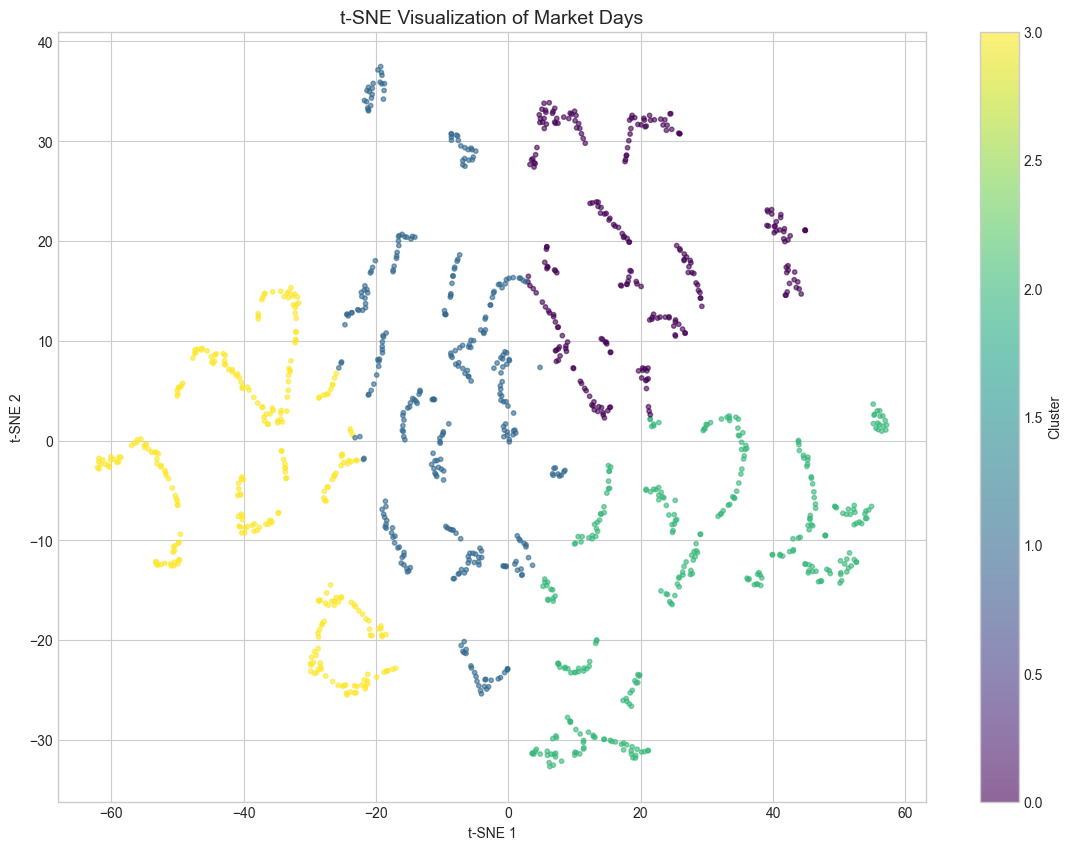

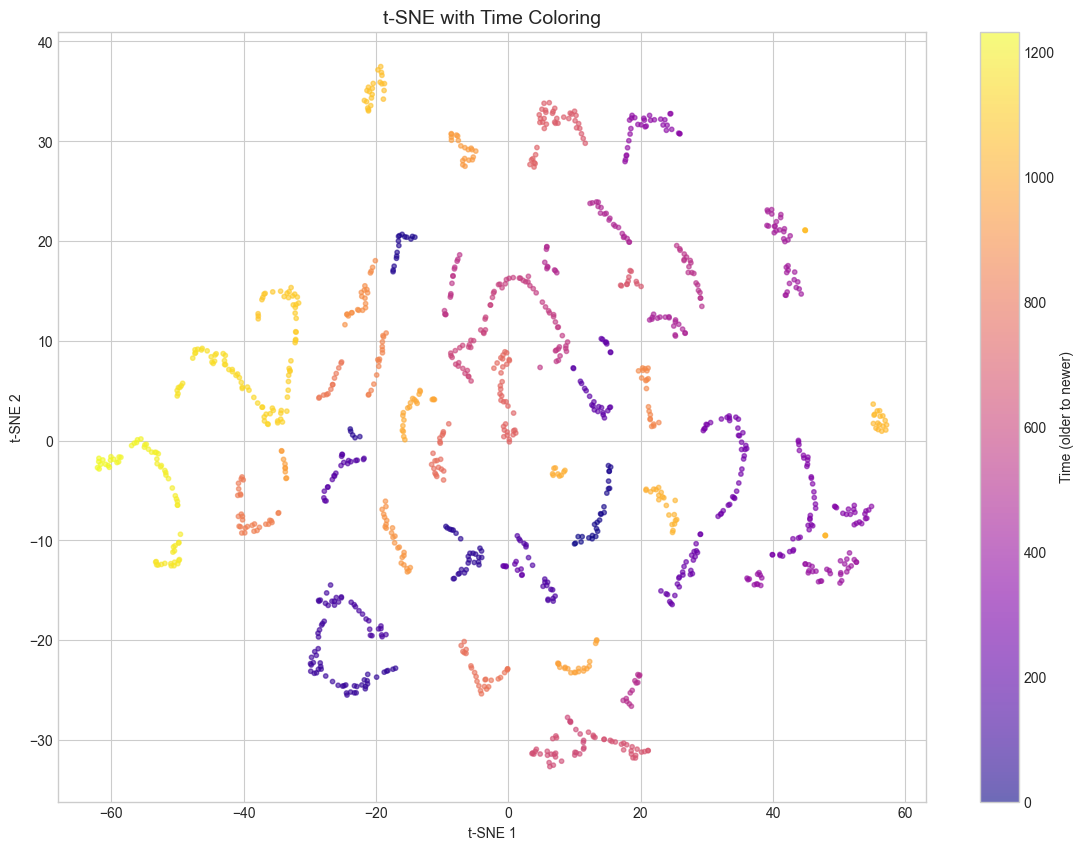

In [4]:
# Cluster the t-SNE output
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_tsne)

# Visualize
plt.figure(figsize=(14, 10))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=10)
plt.colorbar(scatter, label='Cluster')
plt.title('t-SNE Visualization of Market Days', fontsize=14)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Add time coloring
plt.figure(figsize=(14, 10))
time_index = np.arange(len(features))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=time_index, cmap='plasma', alpha=0.6, s=10)
plt.colorbar(scatter, label='Time (older to newer)')
plt.title('t-SNE with Time Coloring', fontsize=14)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [5]:
# Visualize assets in t-SNE space
# Create asset correlation matrix
corr = returns.corr()

# t-SNE on correlation as distance
dist = 1 - corr
tsne_assets = TSNE(n_components=2, random_state=42, perplexity=5, metric='precomputed')
asset_embedded = tsne_assets.fit_transform(dist.values)

plt.figure(figsize=(12, 10))
plt.scatter(asset_embedded[:, 0], asset_embedded[:, 1], s=200, alpha=0.7)
for i, ticker in enumerate(tickers):
    plt.annotate(ticker, (asset_embedded[i, 0], asset_embedded[i, 1]), fontsize=12,
                ha='center', va='bottom')
plt.title('Asset Relationships via t-SNE', fontsize=14)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True, alpha=0.3)
plt.show()

ValueError: The parameter init="pca" cannot be used with metric="precomputed".

In [ ]:
# Analyze clusters (market regimes)
df = features.copy()
df['cluster'] = clusters
df['return'] = returns['SPY'].loc[df.index]
df['volatility'] = returns['SPY'].rolling(20).std().loc[df.index] * np.sqrt(TRADING_DAYS)

print("\n" + "="*60)
print("CLUSTER ANALYSIS (Market Regimes)")
print("="*60)

for c in range(4):
    cluster_data = df[df['cluster'] == c]
    print(f"\nCluster {c} ({len(cluster_data)} days):")
    print(f"  Avg Return: {cluster_data['return'].mean():.4%}")
    print(f"  Avg Volatility: {cluster_data['volatility'].mean():.1%}")
    print(f"  Date Range: {cluster_data.index[0].strftime('%Y-%m')} to {cluster_data.index[-1].strftime('%Y-%m')}")

In [ ]:
# Trading strategy based on cluster transition
df['next_return'] = df['return'].shift(-1)
df['cluster_change'] = (df['cluster'] != df['cluster'].shift(1)).astype(int)

# Strategy: Stay out during regime transitions
df['signal'] = 1  # Default long
df.loc[df['cluster_change'] == 1, 'signal'] = 0  # Out during transitions

df['strategy_return'] = df['signal'] * df['next_return']
df = df.dropna()

df['strategy_cum'] = (1 + df['strategy_return']).cumprod()
df['buy_hold_cum'] = (1 + df['next_return']).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(df.index, df['strategy_cum'], label='Avoid Transitions', linewidth=2)
plt.title('Regime Transition Strategy', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Performance metrics
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - 0.05) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

bh_total, bh_sharpe, bh_mdd = calc_metrics(df['next_return'], df['buy_hold_cum'])
st_total, st_sharpe, st_mdd = calc_metrics(df['strategy_return'], df['strategy_cum'])

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 55)
print(f"{'Buy & Hold':<20} {bh_total:>12.2%} {bh_sharpe:>10.2f} {bh_mdd:>10.2%}")
print(f"{'Avoid Transitions':<20} {st_total:>12.2%} {st_sharpe:>10.2f} {st_mdd:>10.2%}")

In [ ]:
# Current position in regime space
latest_features = features.iloc[[-1]]
latest_scaled = scaler.transform(latest_features)
latest_cluster = clusters[-1]

print("\n" + "="*60)
print("📊 CURRENT MARKET POSITION")
print("="*60)
print(f"\nDate: {features.index[-1].strftime('%Y-%m-%d')}")
print(f"Current Cluster: {latest_cluster}")
print(f"\nCluster {latest_cluster} Characteristics:")
cluster_avg = df[df['cluster'] == latest_cluster]
print(f"  Historical Avg Return: {cluster_avg['return'].mean():.4%}")
print(f"  Historical Avg Volatility: {cluster_avg['volatility'].mean():.1%}")

is_transition = df['cluster_change'].iloc[-1]
print(f"\n🎯 Regime Transition: {'⚠️ YES - Caution' if is_transition else '✅ NO - Stable'}")
print(f"📈 Recommendation: {'Stay out of market' if is_transition else 'Maintain long position'}")

---

## 🏢 Real-World Applications

| Company | Visualization Use |
|---------|------------------|
| Research Teams | Market structure analysis |
| Risk Managers | Regime identification |
| Quant PMs | Asset relationship discovery |

---
## 📅 Tomorrow: Week 9 Review